In [1]:
%matplotlib inline
from __future__ import division
from fileoperations.fileoperations import get_filenames_in_dir
from symbtrdataextractor.dataextractor import DataExtractor
import os 
import json
import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import json


# I/O

In [2]:
sim_thresholds = np.arange(0, 1.001, 0.05)

# get the dataset
txt_folder = os.path.join('turkish_makam_section_dataset', 'txt')
txt_files, txt_folders, txt_names = get_filenames_in_dir(txt_folder, keyword='*.txt')
txt_names = [os.path.splitext(tn)[0] for tn in txt_names]

anno_folder = os.path.join('turkish_makam_section_dataset', 'sections')
save_basefolder = 'experiments'

structure_names = ['melodic_structure', 'lyric_structure']

# Define the wrapper function for experiments

In [3]:
def section_extractor_wrapper(sim_thres):
    # instantiate the extractor
    extractor = DataExtractor(melody_sim_thres=sim_thres, lyrics_sim_thres=sim_thres, 
                              print_warnings=False)

    # initialize the results dictionary
    res_eval = {k:{'overall':{'num_sections':0, 'num_true':0, 'accuracy':-1, 
                              'num_similar_sec':0, 'num_unique_sec':0,
                              'uni_sim_ratio_sec':-1}, 
                   'per_score':[]} for k in structure_names}

    # apply section extraction and analysis to each file
    for tt, tn in zip(txt_files, txt_names):
        # extract ...
        data, is_valid = extractor.extract(tt)
        assert is_valid, '%s has errors' % tt

        # process the sections
        df = pandas.DataFrame.from_dict(data['sections'])
        df = df.reindex_axis(['start_note', 'end_note', 'name', 'melodic_structure', 
                              'lyric_structure' , 'lyrics', 'slug'], axis=1)

        # save results
        save_folder = os.path.join(save_basefolder, str(sim_thres).replace('.', '_'))
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
        save_file = os.path.join(save_folder, tn + '.csv')
        df.to_csv(open(save_file, 'w'), sep='\t', encoding='utf-8', 
                  index=False)

        # evaluate
        anno_file = os.path.join(anno_folder, tn + '.csv')
        anno_df = pandas.read_csv(anno_file, sep='\t', encoding='utf-8')
        for st in structure_names:
            # check labels
            eval_arr = (anno_df[st] == df[st])
            
            # get the number of similar labels and unique labels 
            unique_labels = set(df[st])
            similar_labels = set()
            for lbl in unique_labels:
                if lbl == 'INSTRUMENTAL':
                    similar_labels.add(lbl)
                else:  
                    for ch in lbl:
                        if not ch.isdigit():
                            similar_labels.add(ch)

            res_eval[st]['per_score'].append(
                {'num_sections':len(eval_arr), 'num_true':sum(eval_arr),
                 'accuracy':eval_arr.mean(), 'score':tn, 
                 'num_similar_sec':len(similar_labels),
                 'uni_sim_ratio_sec':len(unique_labels)/len(similar_labels)})

            res_eval[st]['overall']['num_sections'] += len(eval_arr)
            res_eval[st]['overall']['num_true'] += sum(eval_arr)
            res_eval[st]['overall']['num_unique_sec'] += len(unique_labels)
            res_eval[st]['overall']['num_similar_sec'] += len(similar_labels)

    for st in structure_names:
        res_eval[st]['overall']['accuracy'] = (res_eval[st]['overall']['num_true']  / 
                                               res_eval[st]['overall']['num_sections'])
        res_eval[st]['overall']['uni_sim_ratio_sec'] = (res_eval[st]['overall']['num_unique_sec']/ 
                                                    res_eval[st]['overall']['num_similar_sec'])
    return res_eval

# Conduct experiments and aggregate the results


In [4]:
eval_dict = {}
av_mel = []  # average melodic structure accuracy
av_lyr = []  # average lyric structure accuracy
per_mel = []  # melodic structure accuracy per score
per_lyr = []  # lyric structure accuracy per score
num_sim_sec_lyr = []  # total number of similar lyrics labels 
sec_lyr_uni_sim_ratio = []  # ratio between unique and similar lyrics labels 
num_sim_sec_mel = []  # total number of similar melody labels 
sec_mel_uni_sim_ratio = []  # ratio between unique and similar melody labels 
sim_threshold_strs = []
for th in sim_thresholds:
    th_str = str('%.2f' % th)
    sim_threshold_strs.append(th_str)
    eval_dict[th_str] = section_extractor_wrapper(th)
    
    av_mel.append(eval_dict[th_str]['melodic_structure']['overall']['accuracy'])

    av_lyr.append(eval_dict[th_str]['lyric_structure']['overall']['accuracy'])
    
    per_mel.append([mel['accuracy'] 
                   for mel in eval_dict[th_str]['melodic_structure']['per_score']])
    per_lyr.append([lyr['accuracy'] 
                   for lyr in eval_dict[th_str]['lyric_structure']['per_score']
                   if 'sarki' in lyr['score']])
    
    num_sim_sec_mel.append(eval_dict[th_str]['melodic_structure']['overall']['num_similar_sec'])
    sec_mel_uni_sim_ratio.append(eval_dict[th_str]['melodic_structure']['overall']['uni_sim_ratio_sec'])
    
    num_sim_sec_lyr.append(eval_dict[th_str]['lyric_structure']['overall']['num_similar_sec'])
    sec_lyr_uni_sim_ratio.append(eval_dict[th_str]['lyric_structure']['overall']['uni_sim_ratio_sec'])
    
    print '%s: %.2f, %.2f; %d, %.2f; %d, %.2f' % (
        th, av_mel[-1], av_lyr[-1], num_sim_sec_mel[-1], sec_mel_uni_sim_ratio[-1],
        num_sim_sec_lyr[-1], sec_lyr_uni_sim_ratio[-1])

json.dump(eval_dict, open(os.path.join(save_basefolder, 'results.json'), 'w'))

0.0: 0.15, 0.70; 65, 6.29; 79, 1.68
0.05: 0.11, 0.75; 92, 4.45; 79, 1.68
0.1: 0.11, 0.75; 126, 3.25; 79, 1.68
0.15: 0.15, 0.75; 158, 2.59; 83, 1.60
0.2: 0.19, 0.77; 194, 2.11; 93, 1.43
0.25: 0.34, 0.82; 220, 1.86; 100, 1.33
0.3: 0.51, 0.88; 243, 1.68; 109, 1.22
0.35: 0.61, 0.94; 264, 1.55; 117, 1.14
0.4: 0.72, 0.97; 271, 1.51; 123, 1.08
0.45: 0.78, 0.98; 283, 1.45; 126, 1.06
0.5: 0.85, 1.00; 292, 1.40; 128, 1.04
0.55: 0.92, 1.00; 294, 1.39; 129, 1.03
0.6: 0.93, 1.00; 296, 1.38; 129, 1.03
0.65: 0.97, 1.00; 302, 1.35; 129, 1.03
0.7: 0.99, 1.00; 305, 1.34; 129, 1.03
0.75: 0.97, 0.99; 307, 1.33; 130, 1.02
0.8: 0.92, 1.00; 316, 1.29; 130, 1.02
0.85: 0.85, 1.00; 330, 1.24; 130, 1.02
0.9: 0.78, 0.99; 356, 1.15; 131, 1.02
0.95: 0.64, 0.99; 392, 1.04; 132, 1.01
1.0: 0.58, 0.99; 409, 1.00; 133, 1.00


# Plot Results

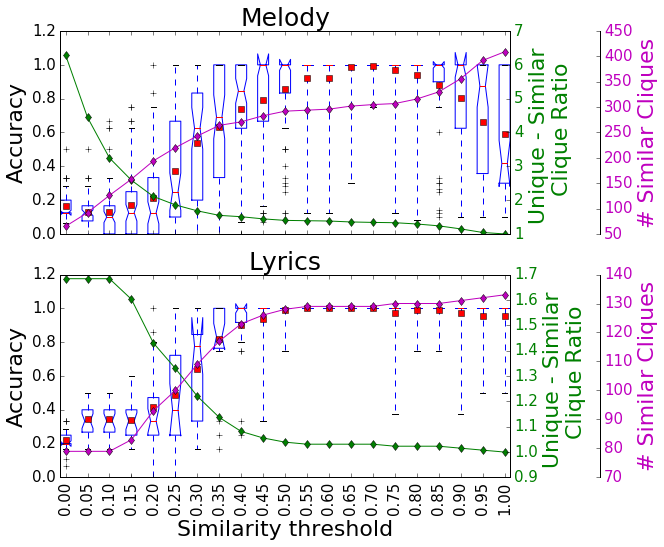

In [6]:
matplotlib.rcParams['figure.figsize'] = (10, 8)
matplotlib.rcParams['ytick.labelsize'] = 15 
matplotlib.rcParams['xtick.labelsize'] = 15 

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

fig, (host1, host2) = plt.subplots(2, 1)
fig.subplots_adjust(right=0.75)
host1.boxplot(per_mel, notch=True, showmeans=True)

host1.set_ylabel('Accuracy', fontsize = 22)
host1.set_title('Melody', fontsize = 25)
matplotlib.pyplot.sca(host1)
plt.setp(host1.get_xticklabels(), visible=False)
plt.xticks(rotation=90)

nn = range(1, len(sec_mel_uni_sim_ratio) + 1)
par11 = host1.twinx()
par11.plot(nn, sec_mel_uni_sim_ratio, 'g-d')
# Make the y-axis label and tick labels match the line color.
for tl in par11.get_yticklabels():
    tl.set_color('g')
par11.set_ylabel('Unique - Similar \n Clique Ratio', fontsize = 22)
par11.yaxis.label.set_color('g')

    
par12 = host1.twinx()
par12.plot(nn, num_sim_sec_mel, 'm-d')    

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
par12.spines["right"].set_position(("axes", 1.2))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(par12)
# Second, show the right spine.
par12.spines["right"].set_visible(True)
for tl in par12.get_yticklabels():
    tl.set_color('m')
par12.set_ylabel('# Similar Cliques', fontsize = 22)
par12.yaxis.label.set_color('m')
    
# lyrics
host2 = plt.subplot(212)

host2.boxplot(per_lyr, notch=True, showmeans=True)
host2.set_xticklabels(sim_threshold_strs)
host2.set_xlabel('Similarity threshold', fontsize = 22)
host2.set_ylabel('Accuracy', fontsize = 22)
host2.set_title('Lyrics', fontsize = 25)
matplotlib.pyplot.sca(host2)
plt.xticks(rotation=90)
# plt.savefig(os.path.join(save_basefolder, "boxplot.pdf"))

par21 = host2.twinx()
par21.plot(nn, sec_lyr_uni_sim_ratio, 'g-d')
# Make the y-axis label and tick labels match the line color.
for tl in par21.get_yticklabels():
    tl.set_color('g')
par21.set_ylabel('Unique - Similar \n Clique Ratio', fontsize = 22)
par21.yaxis.label.set_color('g')

par22 = host2.twinx()
par22.plot(nn, num_sim_sec_lyr, 'm-d')

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
par22.spines["right"].set_position(("axes", 1.2))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(par22)
# Second, show the right spine.
par22.spines["right"].set_visible(True)
for tl in par22.get_yticklabels():
    tl.set_color('m')
par22.set_ylabel('# Similar Cliques', fontsize = 22)
par22.yaxis.label.set_color('m')
plt.savefig(os.path.join(save_basefolder, "boxplot_raw.pdf"))

plt.show()